### Оценка влиянине коэффициента асимметрии распределений случайной величины на расчет характеристик производительности сети.

In [1]:
# Если что-то меняется в коде, мы хотим это сразу видеть здесь
%load_ext autoreload
%autoreload 2

In [35]:
import os

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm

from tabulate import tabulate
from tqdm.notebook import tqdm

from typing import Tuple, List
from itertools import product, chain, repeat
from collections import namedtuple
import time
import numpy as np
import pandas as pd

# Подключаем локальные пакеты
from pyqumo.random import Distribution, Exponential, HyperExponential, Erlang
from pyqumo.cqumo.sim import simulate_tandem

# Поключаем пакеты для ML
import math
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns


from pyqumo.fitting.johnson89 import fit_mern2
from pyqumo.stats import get_std, get_cv, get_skewness, get_noncentral_m2, get_noncentral_m3
from pyqumo.random import HyperErlang

In [3]:
%matplotlib inline
matplotlib.rcParams.update({'font.size': 20})

In [4]:
# Нужно ли пересчитывать все, или можно использовать результаты из файлов
FORCE_SIMULATION = False

# Зададим число пакетов, передачу которых по сети мы будем моделировать.
# Чем выше это число, тем точнее результаты, но на их получение нужно больше времени.
NUM_PACKETS = 1000000

# Цветовая схема для графиков
CMAP_NAME = 'viridis'

## Вызов имитационной модели

In [5]:
COLUMNS = (
    'ArrM1',
    'ArrM2',
    'ArrM3',
    'ArrAvg', 
    'ArrStd', 
    'ArrCv',
    'ArrSkewness',
    'SrvM1',
    'SrvM2',
    'SrvM3',
    'SrvAvg', 
    'SrvStd', 
    'SrvCv',
    'SrvSkewness', 
    'Rho', 
    'NetSize', 
    'Capacity', 
    'NumPackets',
    'DelayAvg', 
    'DelayStd', 
    'DeliveryProb',
)

In [6]:
# def simulate(
#     df: pd.DataFrame, *,
#     arr_m1: float,
#     arr_m2: float,
#     arr_m3: float,
#     srv_m1: float,
#     srv_m2: float,
#     srv_m3: float,
#     net_size: int,
#     capacity: int,
#     num_packets: int,
#     force: bool = False
# ) -> pd.DataFrame:

#     row_df = df[
#         (df.ArrM1 == arr_m1) &
#         (df.ArrM2 == arr_m2) &
#         (df.ArrM3 == arr_m3) &
#         (df.ArrAvg == arr_m1) &
#         (df.ArrM2 == arr_m2) &
#         (df.ArrM3 == arr_m3) &
#         (df.SrvM1 == srv_m1) &
#         (df.SrvM2 == srv_m2) &
#         (df.SrvM3 == srv_m3) &
#         (df.NetSize == net_size) &
#         (df.Capacity == capacity)]
    
#     # Вычислим признаки, которые говорят о необходимости пересчета:
#     no_row = len(row_df) == 0
#     not_enough_packets = (not no_row) and (row_df.NumPackets.iloc[0] < num_packets)

#     # Проверим, нужно ли пересчитать результаты:
#     if force or no_row or not_enough_packets:
#         arr,_  = fit_mern2(moments=[arr_m1, arr_m2, arr_m3], strict=False)
#         srv,_ = fit_mern2(moments=[srv_m1, srv_m2, srv_m3], strict=False)
#         ret = simulate_tandem(arr, [srv] * net_size, capacity, num_packets)

#         row_data = {
#             'ArrM1': arr_m1,
#             'ArrM2': arr_m2,
#             'ArrM3': arr_m3,
#             'ArrAvg': arr_m1,
#             'ArrStd': get_std(arr_m1, arr_m2),
#             'ArrCv': get_cv(arr_m1, arr_m2),
#             'ArrSkewness': get_skewness(arr_m1, arr_m2, arr_m3),
#             'SrvM1': srv_m1,
#             'SrvM2': srv_m2,
#             'SrvM3': srv_m3,
#             'SrvAvg': srv_m1,
#             'SrvStd': get_std(srv_m1, srv_m2),
#             'SrvCv': get_cv(srv_m1, srv_m2),
#             'SrvSkewness': get_skewness(srv_m1, srv_m2, srv_m3),
#             'Rho': arr_m1 / srv_m1,
#             'NetSize': net_size,
#             'Capacity': capacity,
#             'NumPackets': num_packets,
#             'DelayAvg': ret.delivery_delays[0].avg,
#             'DelayStd': ret.delivery_delays[0].std,
#             'DeliveryProb': ret.delivery_prob[0],
#         }
#         # Если строки еще вообще не было, добавляем ее, а если была - обновляем:
#         if no_row:
#             df = df.append(row_data, ignore_index=True)
#         else:
#             df.update(pd.DataFrame(row_data, index=[row_df.index[0]]))

#     return df

In [128]:
def simulate(
    df: pd.DataFrame, *,
    arr_avg: float,
    arr_cv: float,
    arr_skewness: float,
    srv_avg: float,
    srv_cv: float,
    srv_skewness: float,
    net_size: int,
    capacity: int,
    num_packets: int,
    force: bool = False
) -> pd.DataFrame:

    # row_df = df[
    #     (df.ArrAvg == arr_m1) &
    #     (df.ArrCV == arr_m2) &
    #     (df.ArrM3 == arr_m3) &
    #     (df.ArrAvg == arr_m1) &
    #     (df.ArrM2 == arr_m2) &
    #     (df.ArrM3 == arr_m3) &
    #     (df.SrvM1 == srv_m1) &
    #     (df.SrvM2 == srv_m2) &
    #     (df.SrvM3 == srv_m3) &
    #     (df.NetSize == net_size) &
    #     (df.Capacity == capacity)]
    
    # # Вычислим признаки, которые говорят о необходимости пересчета:
    # no_row = len(row_df) == 0
    # not_enough_packets = (not no_row) and (row_df.NumPackets.iloc[0] < num_packets)

    arr_m1 = arr_avg
    arr_m2 = get_noncentral_m2(arr_m1, arr_cv)
    arr_m3 = get_noncentral_m3(arr_m1, arr_cv, arr_skewness)

    srv_m1 = srv_avg
    srv_m2 = get_noncentral_m2(srv_m1, srv_cv)
    srv_m3 = get_noncentral_m3(srv_m1, srv_cv, srv_skewness)


    # # Проверим, нужно ли пересчитать результаты:
    # if force or no_row or not_enough_packets:
    arr,_  = fit_mern2(moments=[arr_m1, arr_m2, arr_m3], strict=False)
    srv,_ = fit_mern2(moments=[srv_m1, srv_m2, srv_m3], strict=False)
    ret = simulate_tandem(arr, [srv] * net_size, capacity, num_packets)

    row_data = {
        'ArrM1': arr_m1,
        'ArrM2': arr_m2,
        'ArrM3': arr_m3,
        'ArrAvg': arr_m1,
        'ArrStd': get_std(arr_m1, arr_m2),
        'ArrCv': arr_cv,
        'ArrSkewness': arr_skewness,
        'SrvM1': srv_m1,
        'SrvM2': srv_m2,
        'SrvM3': srv_m3,
        'SrvAvg': srv_m1,
        'SrvStd': get_std(srv_m1, srv_m2),
        'SrvCv': srv_cv,
        'SrvSkewness': srv_skewness,
        'Rho': arr_m1 / srv_m1,
        'NetSize': net_size,
        'Capacity': capacity,
        'NumPackets': num_packets,
        'DelayAvg': ret.delivery_delays[0].avg,
        'DelayStd': ret.delivery_delays[0].std,
        'DeliveryProb': ret.delivery_prob[0],
    }
    # # Если строки еще вообще не было, добавляем ее, а если была - обновляем:
    # if no_row:
    #     df = df.append(row_data, ignore_index=True)
    # else:
    #     df.update(pd.DataFrame(row_data, index=[row_df.index[0]]))
    df = df.append(row_data, ignore_index=True)

    return df

In [7]:
def get_m2(m1: float, cv:float) -> float:
    """Compute the 2nd moment.
    """
    return (m1 * cv) ** 2 + m1 ** 2 


def get_m3(m1: float, m2: float, skewness:float) -> float:
    """Compute the 3rd moment.
    """
    std = m1 * m2
    var = std ** 2
    # var = m2 - m1**2
    # std = var**0.5
    return var * std * skewness + 3*m1*var - m1**3

### Влияние коэффициента ассиметрии распределения времени поступления пакетов на времея задержки в сети.

Рассмотрим сеть с одной фазой в которой будем варьировать коэффициентом вариации $ArrCv \in [0; \infty)$ и коэффициентом ассиметрии $\gamma \in [ArrCV - \dfrac{1}{ArrCV}; \infty)$

In [170]:
def prepare_dist_params(mean: list, cv:list, 
                        skewness_max: int=100, 
                        point_number: int=80,
                        fix_params: bool=False
                        ) -> Tuple[List[float],
                                   List[float],
                                   List[float]]:
    """ 
    Prepare distribution parameter lists
        for simulation model
    """
    skewness_vector = []
    if fix_params:
        for i in range(len(cv)):
            skewness_min = cv[i] - 1/ cv[i]
            skewness_vector = [skewness_min]*point_number
    else:
        for i in range(len(cv)):
            skewness_min = cv[i] - 1/ cv[i]
            skewness_count = int(point_number/len(cv))
            skewness_vector = skewness_vector + list(np.linspace(skewness_min, 
                                                                 skewness_max, 
                                                                 skewness_count))

    cv_count = int(point_number / len(cv))
    cv_vector = list(chain.from_iterable(zip(*repeat(cv, cv_count))))
    mean_vector = mean * point_number

    return mean_vector, cv_vector, skewness_vector    

In [191]:
POINT_NUMBER = 80
ARR_M1 = [1]
ARR_CV = [0.9 ,1, 2, 3]
NET_SIZE = [1]
CAPACITY = [6]
arr_avg, arr_cv, arr_skewness = prepare_dist_params(ARR_M1,  
                                                    ARR_CV,
                                                    point_number=POINT_NUMBER)

SRV_M1 = [0.5]
SRV_CV = [0.9]

srv_avg, srv_cv, srv_skewness = prepare_dist_params(SRV_M1,  
                                                    SRV_CV, 
                                                    point_number=POINT_NUMBER,
                                                    fix_params=True)
net_size = NET_SIZE*POINT_NUMBER
capacity = CAPACITY*POINT_NUMBER

check_arr_skewness_data = pd.DataFrame(columns=COLUMNS)
# Выполним симуляцию:
for i in tqdm(range(len(arr_avg))):
    check_arr_skewness_data = simulate(
        check_arr_skewness_data,
        arr_avg=arr_avg[i],
        arr_cv=arr_cv[i],
        arr_skewness=arr_skewness[i],
        srv_avg=srv_avg[i],
        srv_cv=srv_cv[i],
        srv_skewness=srv_skewness[i],
        net_size=net_size[i],
        capacity=capacity[i],
        num_packets=NUM_PACKETS,
        force=FORCE_SIMULATION
    )

  0%|          | 0/80 [00:00<?, ?it/s]

previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previo

In [10]:
# POINTS_NUMBER = 20
# ARR_CV = [0.9 ,1, 2, 3]
# ARR_M1 = [1] * len(ARR_CV) * POINTS_NUMBER
# ARR_SKEWNESS = []

# for i in range(len(ARR_CV)):
#     skewnes_min = ARR_CV[i] - 1/ARR_CV[i]
#     step = 5
#     skewness_max = ARR_CV[i] - 1/ARR_CV[i] + POINTS_NUMBER*step
#     ARR_SKEWNESS += list(np.linspace(skewnes_min, POINTS_NUMBER*step, POINTS_NUMBER))

# ARR_CV = [[i] * POINTS_NUMBER for i in ARR_CV]
# ARR_CV = list(chain(*ARR_CV))

# ARR_M2 = [get_noncentral_m2(arr_m1, cv) for cv, arr_m1 in zip(ARR_CV, ARR_M1)]
# ARR_M3 = [get_noncentral_m3(ARR_M1[i], ARR_CV[i], ARR_SKEWNESS[i]) for i in range(len(ARR_CV))]

# SRV_M1 = [0.5] * len(ARR_CV)

# SRV_M2 = [9] * len(ARR_CV)End-to-end delay'
# SRV_M3 = [10000] * len(ARR_CV)
# NET_SIZE = [1] * len(ARR_CV)
# CAPACITY = [6] * len(ARR_CV)

# check_arr_skewness_data = pd.DataFrame(columns=COLUMNS)
# # Выполним симуляцию:
# for i in tqdm(range(len(ARR_CV))):
#     check_arr_skewness_data = simulate(
#         check_arr_skewness_data,
#         arr_m1=ARR_M1[i],
#         arr_m2=ARR_M2[i],
#         arr_m3=ARR_M3[i],
#         srv_m1=SRV_M1[i],
#         srv_m2=SRV_M2[i],
#         srv_m3=SRV_M3[i],
#         net_size=NET_SIZE[i],
#         capacity=CAPACITY[i],
#         num_packets=NUM_PACKETS,
#         force=FORCE_SIMULATION
#     )


  0%|          | 0/80 [00:00<?, ?it/s]

previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  0.0
new gamma:  2.0
previous gamma:  1.5
new gamma:  1.7999999999999998
previous gamma:  2.6666666666666665
new gamma:  3.1999999999999997


In [176]:
check_arr_skewness_data

,ArrM1,ArrM2,ArrM3,ArrAvg,ArrStd,ArrCv,ArrSkewness,SrvM1,SrvM2,SrvM3,...,SrvStd,SrvCv,SrvSkewness,Rho,NetSize,Capacity,NumPackets,DelayAvg,DelayStd,DeliveryProb
0,1.0,1.81,3.276100,1.0,0.9,0.9,-0.211111,0.5,0.5,0.5,...,0.5,1.0,0.0,2.0,1.0,6.0,1000000.0,1.061594,1.006325,0.989809
1,1.0,1.81,7.121042,1.0,0.9,0.9,5.063158,0.5,0.5,0.5,...,0.5,1.0,0.0,2.0,1.0,6.0,1000000.0,0.789714,0.783499,0.999582
2,1.0,1.81,10.965984,1.0,0.9,0.9,10.337427,0.5,0.5,0.5,...,0.5,1.0,0.0,2.0,1.0,6.0,1000000.0,0.752297,0.746034,0.999781
3,1.0,1.81,14.810926,1.0,0.9,0.9,15.611696,0.5,0.5,0.5,...,0.5,1.0,0.0,2.0,1.0,6.0,1000000.0,0.739876,0.733232,0.999833
4,1.0,1.81,18.655868,1.0,0.9,0.9,20.885965,0.5,0.5,0.5,...,0.5,1.0,0.0,2.0,1.0,6.0,1000000.0,0.732927,0.727212,0.999850
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1.0,10.00,2174.736842,1.0,3.0,3.0,79.508772,0.5,0.5,0.5,...,0.5,1.0,0.0,2.0,1.0,6.0,1000000.0,1.011405,0.976479,0.994915
76,1.0,10.00,2313.052632,1.0,3.0,3.0,84.631579,0.5,0.5,0.5,...,0.5,1.0,0.0,2.0,1.0,6.0,1000000.0,1.012203,0.977943,0.994710
77,1.0,10.00,2451.368421,1.0,3.0,3.0,89.754386,0.5,0.5,0.5,...,0.5,1.0,0.0,2.0,1.0,6.0,1000000.0,1.002563,0.966185,0.995118
78,1.0,10.00,2589.684211,1.0,3.0,3.0,94.877193,0.5,0.5,0.5,...,0.5,1.0,0.0,2.0,1.0,6.0,1000000.0,0.998305,0.962598,0.995183


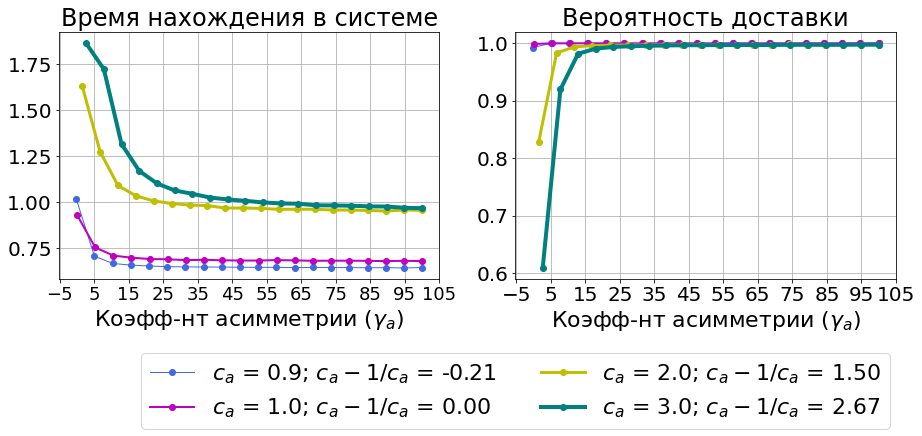

In [193]:
fig = plt.figure(figsize=(15, 10))

ax = fig.add_subplot(2, 2, 1)
color = ['royalblue', 'm', 'y', 'teal']
plt.title('Время нахождения в системе', fontsize='24')
for i in range(len(check_arr_skewness_data['ArrCv'].unique())):
    arr_cv = check_arr_skewness_data['ArrCv'].unique()[i]
    data = check_arr_skewness_data[check_arr_skewness_data['ArrCv'] == arr_cv]
    ax.plot(data['ArrSkewness'], data['DelayAvg'], 
            color=color[i], marker='o', linewidth= 1 + i,  
            label=f'$c_a$ = {arr_cv};  $c_a - 1/ c_a$ = {arr_cv - 1/arr_cv:.3f}')
plt.xticks(np.arange(-5, 110, 10), fontsize='18')  
plt.xlabel('Коэфф-нт асимметрии ' + r'($\gamma_a$)', fontsize='22')
plt.grid()

ax = fig.add_subplot(2, 2, 2)
plt.title('Вероятность доставки', fontsize='24')

for i in range(len(check_arr_skewness_data['ArrCv'].unique())):
    arr_cv = check_arr_skewness_data['ArrCv'].unique()[i]
    data = check_arr_skewness_data[check_arr_skewness_data['ArrCv'] == arr_cv] 
    plt.plot(data['ArrSkewness'], data['DeliveryProb'], 
             color=color[i], marker='o', linewidth= 1 + i, 
             label=f'$c_a$ = {arr_cv}; $c_a - 1/ c_a$ = {arr_cv - 1/arr_cv:.2f}')
plt.xticks(np.arange(-5, 115, 10), fontsize='20')   
plt.xlabel('Коэфф-нт асимметрии ' + r'($\gamma_a$)', fontsize='22')
plt.grid()

ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0, -0.65), prop={'size': 22})
plt.savefig('data/images/arrival_skewness_influence.pdf', bbox_inches = 'tight')

### Влияние коэффициента ассиметрии распределения времени обслуживания пакетов на время задержки в сети.

Теперь будем варьировать коэффициентом вариации распределения времени осблуживания $SrvCv \in [0; \infty)$ и коэффициентом ассиметрии $\gamma \in [SrvCV - \dfrac{1}{SrvCV}; \infty)$

In [179]:
POINT_NUMBER = 80
SRV_M1 = [.5]
SRV_CV = [0.9 ,1, 2, 3]
SRV_SIZE = [1]
CAPACITY = [6]
srv_avg, srv_cv, srv_skewness = prepare_dist_params(SRV_M1,  
                                                    SRV_CV,
                                                    point_number=POINT_NUMBER)

ARR_M1 = [1]
ARR_CV = [0.9]

arr_avg, arr_cv, arr_skewness = prepare_dist_params(ARR_M1,  
                                                    ARR_CV, 
                                                    point_number=POINT_NUMBER,
                                                    fix_params=True)
net_size = NET_SIZE*POINT_NUMBER
capacity = CAPACITY*POINT_NUMBER

check_srv_skewness_data = pd.DataFrame(columns=COLUMNS)
# Выполним симуляцию:
for i in tqdm(range(len(arr_avg))):
    check_srv_skewness_data = simulate(
        check_srv_skewness_data,
        arr_avg=arr_avg[i],
        arr_cv=arr_cv[i],
        arr_skewness=arr_skewness[i],
        srv_avg=srv_avg[i],
        srv_cv=srv_cv[i],
        srv_skewness=srv_skewness[i],
        net_size=net_size[i],
        capacity=capacity[i],
        num_packets=NUM_PACKETS,
        force=FORCE_SIMULATION
    )

  0%|          | 0/80 [00:00<?, ?it/s]

previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previo

In [13]:
# POINTS_NUMBER = 20
# SRV_CV = [0.9 ,1, 2, 3]
# SRV_M1 = [0.5] * len(SRV_CV) * POINTS_NUMBER
# SRV_SKEWNESS = []

# for i in range(len(SRV_CV)):
#     skewnes_min = SRV_CV[i] - 1/SRV_CV[i]
#     step = 5
#     skewness_max = SRV_CV[i] - 1/SRV_CV[i] + POINTS_NUMBER*step
#     SRV_SKEWNESS += list(np.linspace(skewnes_min, POINTS_NUMBER*step, POINTS_NUMBER))
# print(skewnes_min)
# SRV_CV = [[i] * POINTS_NUMBER for i in SRV_CV]
# SRV_CV = list(chain(*SRV_CV))
# # SRV_M2 = [get_m2(srv_m1, cv) for cv, srv_m1 in zip(SRV_CV, SRV_M1)]
# # SRV_M3 = [get_m3(SRV_M1[i], SRV_M2[i], SRV_SKEWNESS[i]) for i in range(len(SRV_CV))]
# SRV_M2 = [get_noncentral_m2(srv_m1, cv) for cv, srv_m1 in zip(SRV_CV, SRV_M1)]
# SRV_M3 = [get_noncentral_m3(SRV_M1[i], SRV_CV[i], SRV_SKEWNESS[i]) for i in range(len(SRV_CV))]

# ARR_M1 = [1] * len(SRV_CV)
# ARR_M2 = [9] * len(SRV_CV)
# ARR_M3 = [10000] * len(SRV_CV)
# NET_SIZE = [1] * len(SRV_CV)
# CAPACITY = [6] * len(SRV_CV)

# check_srv_skewness_data = pd.DataFrame(columns=COLUMNS)
# # Выполним симуляцию:
# for i in tqdm(range(len(ARR_CV))):
#     check_srv_skewness_data = simulate(
#         check_srv_skewness_data,
#         arr_m1=ARR_M1[i],
#         arr_m2=ARR_M2[i],
#         arr_m3=ARR_M3[i],
#         srv_m1=SRV_M1[i],
#         srv_m2=SRV_M2[i],
#         srv_m3=SRV_M3[i],
#         net_size=NET_SIZE[i],
#         capacity=CAPACITY[i],
#         num_packets=NUM_PACKETS,
#         force=FORCE_SIMULATION
#     )


2.6666666666666665


  0%|          | 0/80 [00:00<?, ?it/s]

previous gamma:  -0.21111111111111128
new gamma:  -0.16888888888888903
previous gamma:  0.0
new gamma:  2.0
previous gamma:  1.5
new gamma:  1.7999999999999998
previous gamma:  2.6666666666666665
new gamma:  3.1999999999999997


In [180]:
check_srv_skewness_data

,ArrM1,ArrM2,ArrM3,ArrAvg,ArrStd,ArrCv,ArrSkewness,SrvM1,SrvM2,SrvM3,...,SrvStd,SrvCv,SrvSkewness,Rho,NetSize,Capacity,NumPackets,DelayAvg,DelayStd,DeliveryProb
0,1.0,1.81,3.2761,1.0,0.9,0.9,-0.211111,0.5,0.4525,0.409513,...,0.45,0.9,-0.211111,2.0,1.0,6.0,1000000.0,1.020489,0.912668,0.992711
1,1.0,1.81,3.2761,1.0,0.9,0.9,-0.211111,0.5,0.4525,0.890130,...,0.45,0.9,5.063158,2.0,1.0,6.0,1000000.0,1.055633,0.991629,0.989564
2,1.0,1.81,3.2761,1.0,0.9,0.9,-0.211111,0.5,0.4525,1.370748,...,0.45,0.9,10.337427,2.0,1.0,6.0,1000000.0,1.042864,1.053850,0.987811
3,1.0,1.81,3.2761,1.0,0.9,0.9,-0.211111,0.5,0.4525,1.851366,...,0.45,0.9,15.611696,2.0,1.0,6.0,1000000.0,1.028068,1.089564,0.987534
4,1.0,1.81,3.2761,1.0,0.9,0.9,-0.211111,0.5,0.4525,2.331984,...,0.45,0.9,20.885965,2.0,1.0,6.0,1000000.0,1.010522,1.094122,0.987831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1.0,1.81,3.2761,1.0,0.9,0.9,-0.211111,0.5,2.5000,271.842105,...,1.50,3.0,79.508772,2.0,1.0,6.0,1000000.0,1.153070,4.004807,0.970592
76,1.0,1.81,3.2761,1.0,0.9,0.9,-0.211111,0.5,2.5000,289.131579,...,1.50,3.0,84.631579,2.0,1.0,6.0,1000000.0,1.145713,3.991384,0.972251
77,1.0,1.81,3.2761,1.0,0.9,0.9,-0.211111,0.5,2.5000,306.421053,...,1.50,3.0,89.754386,2.0,1.0,6.0,1000000.0,1.138111,3.632795,0.973725
78,1.0,1.81,3.2761,1.0,0.9,0.9,-0.211111,0.5,2.5000,323.710526,...,1.50,3.0,94.877193,2.0,1.0,6.0,1000000.0,1.134144,3.870552,0.974482


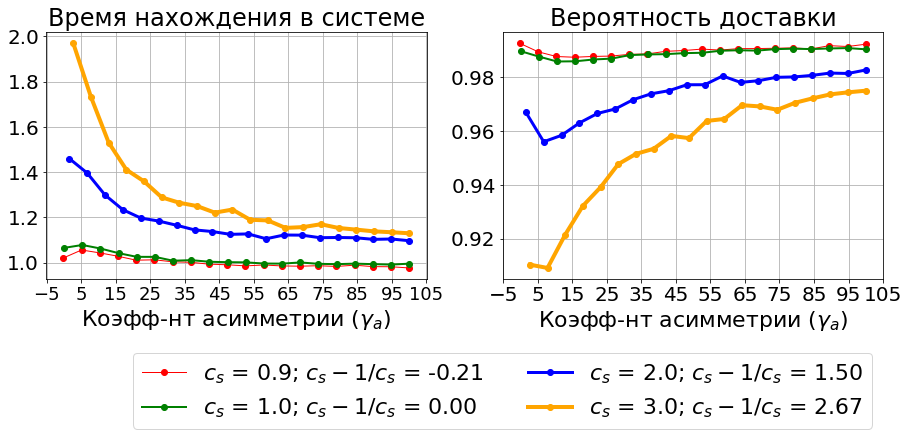

In [188]:
fig = plt.figure(figsize=(15, 10))
# End2end delay
ax = fig.add_subplot(2, 2, 1)
color = ['r', 'g', 'b', 'orange']
plt.title('Время нахождения в системе', fontsize='24')
for i in range(len(check_srv_skewness_data['SrvCv'].unique())):
    srv_cv = check_srv_skewness_data['SrvCv'].unique()[i]
    data = check_srv_skewness_data[check_srv_skewness_data['SrvCv'] == srv_cv]
    ax.plot(data['SrvSkewness'], data['DelayAvg'], 
            color=color[i], marker='o', linewidth= 1 + i, 
            label=f'$c_s$ = {srv_cv};  $c_s - 1/ c_s$ = {srv_cv - 1/srv_cv:.3f}')
plt.xticks(np.arange(-5, 110, 10), fontsize='18')  
plt.xlabel('Коэфф-нт асимметрии ' + r'($\gamma_a$)', fontsize='22')
plt.grid()

# Delivery probability
ax = fig.add_subplot(2, 2, 2)
plt.title('Вероятность доставки', fontsize='24')
for i in range(len(check_srv_skewness_data['SrvCv'].unique())):
    srv_cv = check_srv_skewness_data['SrvCv'].unique()[i]
    data = check_srv_skewness_data[check_srv_skewness_data['SrvCv'] == srv_cv] 
    plt.plot(data['SrvSkewness'], data['DeliveryProb'], 
             color=color[i], marker='o', linewidth= 1 + i, 
             label=f'$c_s$ = {srv_cv}; $c_s - 1/ c_s$ = {srv_cv - 1/srv_cv:.2f}')
plt.xticks(np.arange(-5, 110, 10), fontsize='20')   
plt.xlabel('Коэфф-нт асимметрии ' + r'($\gamma_a$)', fontsize='22')
plt.grid()
ax.legend(loc='lower center', ncol=2, bbox_to_anchor=(0, -0.65), prop={'size': 22})
plt.savefig('data/images/service_skewness_influence.pdf', bbox_inches = 'tight')
